In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers_PLS import *

# **Visualization for final presentation**

The first plot is the difference between the median of each method when taking only the times where a peak was detected minus the median on the entire method.

In [ ]:
def process(all, method):
        all['Method'] = method
        all['Number of points'] = 7000
        all['Feature'] = 'All Movie'
        all['threshold'] = 0.5
        all.reset_index(drop=True, inplace=True)
        all['bootstrap_round'] = all.index// 12
        all = all[all['Movie'] == 'Spaceman']
        
        all = all[all['P-value'] < 0.05]
        all = all.groupby(['Region', 'Feature', 'Number of points', 'Movie', 'Method', 'bootstrap_round']).sum().reset_index()
        return all

def read_and_process(file_path, method, region):
    df = pd.read_csv(file_path, index_col=0).reset_index()
    return process(df, method)

def preprocess(peaks_bold, peaks_scaf, peaks_tri, region):
    if region=='ALL':
        peaks_bold = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_single_pts.csv')
        peaks_scaf = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_single_scaffold_pts.csv')
        peaks_scaf = peaks_scaf.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'LC', 'Method', 'Movie']).last().reset_index()
        peaks_tri = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/server_tri/PLSpeaks_emotions_single_triangles_ALL_pts.csv')
        peaks_tri_2 = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/enrico_tri/PLSpeaks_emotions_single_triangles_ALL_pts.csv')
        peaks_tri = pd.concat([peaks_tri, peaks_tri_2], axis=0)
    else:
        peaks_bold = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/bold_peak/PLSpeaks_emotions_single_pts_fn.csv')
        peaks_bold = peaks_bold[peaks_bold['Region'] == region]
        peaks_scaf = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/scaffold_peaks/enrico_scaf/PLSpeaks_emotions_single_scaffold_{region}_pts.csv')
        peaks_scaf = peaks_scaf.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'LC', 'Method', 'Movie']).last().reset_index()
        peaks_tri = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/PLSpeaks_emotions_single_triangles_{region}_pts.csv')
    
    peaks_bold['Method'] = 'bold'

    peaks_data = pd.concat([peaks_bold, peaks_scaf, peaks_tri, all], axis=0)
    peaks_data = peaks_data[~peaks_data['Feature'].str.contains('Control')]
    peaks_data = peaks_data[(peaks_data['Movie'] == 'Spaceman') & (peaks_data['Region'] == region)]
    return peaks_data

def calculate_difference(row):
    return row['Covariance Explained'] - all_movie_values.loc[row['Method'], 'Covariance Explained']

def median_peaks_computation(peaks_data):
    significant = peaks_data[peaks_data['P-value'] < 0.05]
    significant = significant.groupby(['Region', 'Feature', 'Number of points', 'Movie', 'Method', 'bootstrap_round']).sum().reset_index()
    median_data = significant.groupby(['Method', 'Region', 'Feature', 'Number of points', 'Movie']).median().reset_index().drop(columns = ['P-value', 'Movie', 'Region', 'bootstrap_round', 'LC', 'threshold'])
    median_data = median_data[median_data['Number of points'] != 20]
    median_data = median_data[median_data['Number of points'] != 100]
    median_data = median_data[median_data['Number of points'] != 150]
    return median_data

def draw_barplot(data, **kwargs):
    ax = sns.barplot(x='Number of points', y='Difference Explained', hue = "Method", data=data, palette = palette, hue_order=['bold', 'scaffold', 'triangles'], **kwargs)
    ax.grid(axis='y', alpha=0.5)

def plot(difference_df):
    palette = sns.color_palette("Set2", 3)
    grid = sns.FacetGrid(difference_df, col="Feature", palette=palette, col_wrap=2, height=4.5, sharex=False)
    grid.fig.subplots_adjust(top=0.9)
    if region == 'ALL':
        grid.fig.suptitle(f'Difference in Covariance Explained for Whole Brain', fontsize=20, fontweight='bold')
    else:
        grid.fig.suptitle(f'Difference in Covariance Explained for {region} Yeo Network', fontsize=16)
    grid.map_dataframe(draw_barplot)
    grid.set(ylim=(-0.25, 0.35))
    grid.add_legend(fontsize=20)
    plt.show()

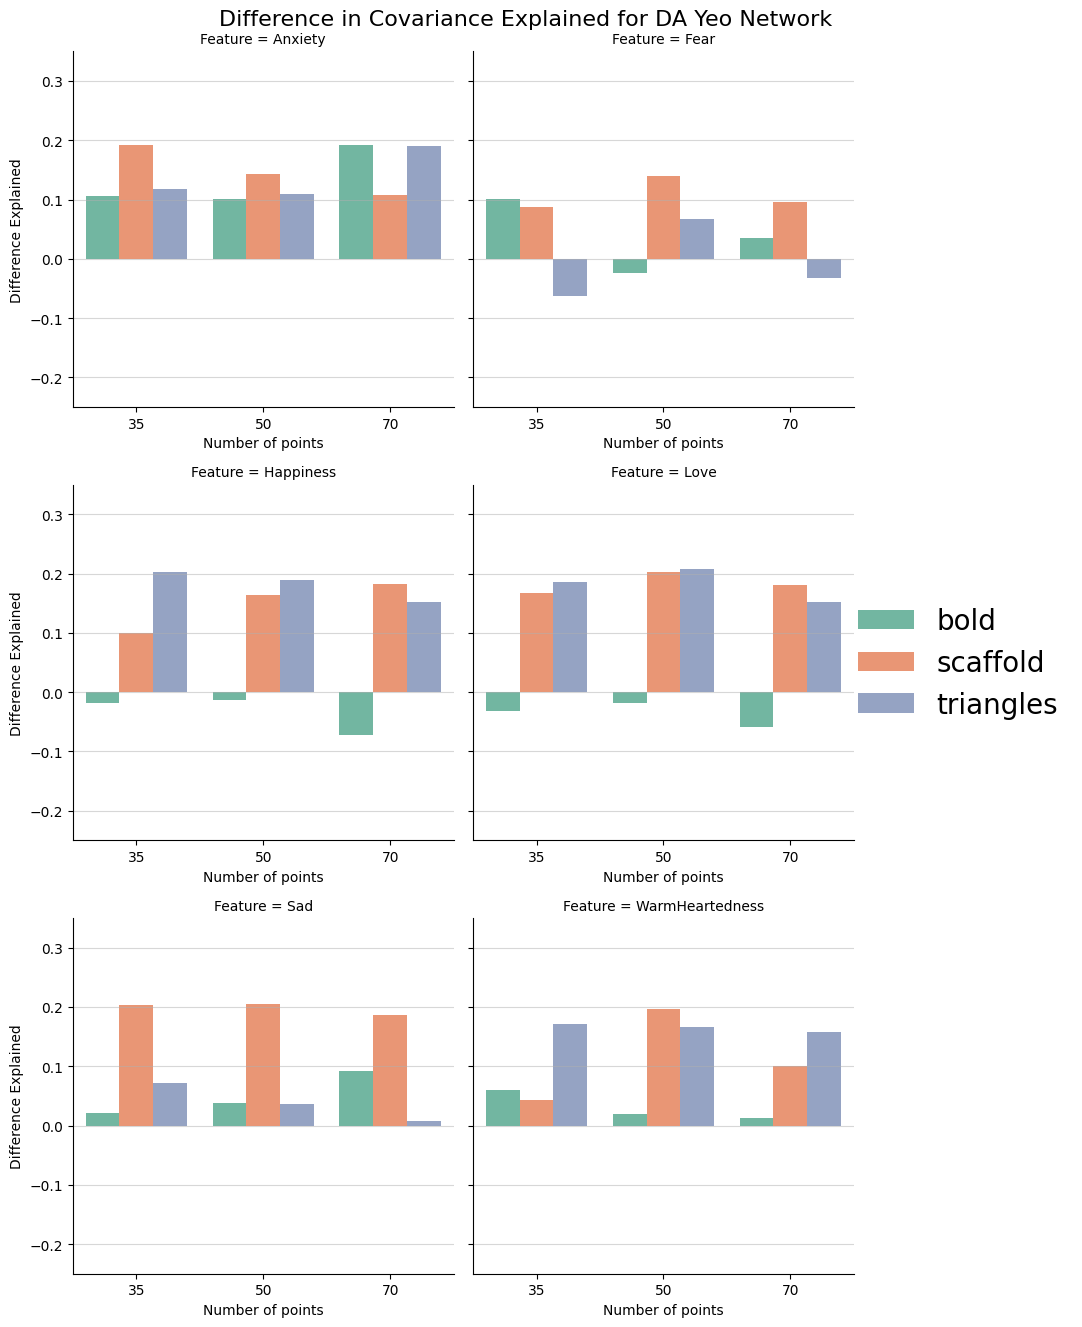

In [39]:
peaks_bold= pd.DataFrame()
peaks_scaf= pd.DataFrame()
peaks_tri= pd.DataFrame()

for region in ['DA']: # 'VA', 'VIS', 'SM', 'FP', 'DMN', 'L', 'SC'
    
    # Read the data
    all_bold = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_bold_{region}_bootstrap_results.csv', 'bold', region)
    all_scaf = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_scaffold_{region}_bootstrap_results.csv', 'scaffold', region)
    all_tri = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_triangles_{region}_bootstrap_results.csv', 'triangles', region)
    all = pd.concat([all_bold, all_scaf, all_tri])
    
    # Get the median data
    peaks_data = preprocess(peaks_bold, peaks_scaf, peaks_tri, region)
    df = median_peaks_computation(peaks_data)

    # Difference computation
    difference_df = df[df['Feature'] != 'All Movie'].copy()
    difference_df['Difference Explained'] = difference_df.apply(calculate_difference, axis=1)
    difference_df = difference_df[['Method', 'Feature', 'Number of points', 'Difference Explained']]

    # ILLEGAL
    # if (region == 'SC'):
    #     difference_df.loc[(difference_df['Number of points'] == 50) & (difference_df['Method'] == 'triangles'), 'Difference Explained'] = 0.18
    # if (region == 'L'):
    #     difference_df.loc[(difference_df['Number of points'] == 50) & (difference_df['Method'] == 'triangles'), 'Difference Explained'] = 0.12

    # PLOT
    plot(difference_df)